In [69]:
import numpy as np
from copy import deepcopy
from spglm.iwls import iwls, _compute_betas_gwr
from spglm.family import *
from mgwr.search import golden_section
import pandas as pd
import statsmodels.api as sm
import geopandas as gp
import matplotlib.pyplot as plt

In [185]:
# local scoring - outer loop
def local_score(y, X, verbose=False):
    s_0 = np.log(np.mean(y))
    eta = s_0.reshape((-1, 1))
    s_old = np.zeros_like(X)
    crit = 9999
    while crit > 1e-8:
        mu = np.exp(eta).reshape((-1, 1))
        w = mu.reshape((-1,1))
        z = eta + ((y.reshape((-1, 1)) - mu) / mu)
        betas, X = backfit(z, X, w, verbose=verbose)
        s_new = np.multiply(betas.T, np.log(X))
        inner = np.sum((s_old - s_new)**2, axis=1)
        num = np.sum(w*inner)
        den = np.sum(w*np.sum((1 + s_old)**2, axis=1).reshape((-1, 1)))
        crit = num / den
        eta = np.sum(s_new, axis=1).reshape((-1, 1))
        s_old = s_new
    return betas, eta

In [792]:
def access(y, m, d, sigma):
    W = sw.distance.DistanceBand.from_dataframe(austria_shp, threshold=99999, binary=False, alpha=sigma)
    W = W.full()[0]
    mask = W!=0
    Aij = (W * Dja[0:9])
    Aij = Aij[mask].reshape((9,8))
    Aij = np.tile(np.sum(Aij, axis=1), 9).reshape((9,9))
    Aij = Aij[mask].reshape((-1,1))
    mod = sm.OLS(y, np.log(Aij)).fit()
    print(sigma, mod.aic)
    return mod.aic


# backfitting - inner loop
def backfit(y, X, w, verbose=False):
    n,k = X.shape
    betas = _compute_betas_gwr(y, np.log(X), w.reshape((-1, 1)))[0]
    print(betas)
    XB = np.multiply(betas.T, np.log(X))
    yhat = np.dot(np.log(X), betas)
    err = y.reshape((-1, 1)) - yhat
    iters = 0
    scores = []
    delta = 1e6
    tol = 1e-8
    max_iter = 50

    for iters in range(1, max_iter + 1):
        new_XB = np.zeros_like(X)
        params = np.zeros_like(betas)

        for j in range(k):
            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err.reshape((-1, 1))
            temp_X = np.log(X[:, j]).reshape((-1, 1))

            if j == 3:
                score = lambda x: access(temp_y, X[:, 1].reshape((-1, 1)), X[:, 2].reshape((-1, 1)), x)
                sig  = golden_section(-6, 6, 0.38197, score, 1e-2, 50)[0]
                print(sig)
                W = sw.distance.DistanceBand.from_dataframe(austria_shp, threshold=99999, binary=False, alpha=sig)
                W = W.full()[0]
                mask = W!=0
                Aij = (W * Dja[0:9])
                Aij = Aij[mask].reshape((9,8))
                Aij = np.tile(np.sum(Aij, axis=1), 9).reshape((9,9))
                Aij = Aij[mask].reshape((-1,1))
                X[:, j] = Aij.flatten()
                temp_X = np.log(Aij).reshape((-1, 1))

            
            beta = _compute_betas_gwr(temp_y, temp_X, w.reshape((-1, 1)))[0]
            print(beta)
            yhat = np.dot(temp_X, beta)
            new_XB[:, j] = yhat.flatten()
            err = (temp_y - yhat).reshape((-1, 1))
            params[j, :] = beta[0][0]
    
        num = np.sum((XB-new_XB)**2)
        den = 1 + np.sum(np.sum(XB, axis=1)**2)
        score = (num / den)
        XB = new_XB
        
        scores.append(deepcopy(score))
        delta = score

        if verbose:
            print("Current iteration:", iters, ",SOC:", np.round(score, 8))
        if delta < tol:
            break

    return params, X

In [314]:
x1 = np.random.normal(5,.5, (625,1))
x2 = np.random.normal(5,.5, (625,1))
x3 = np.random.normal(5,.5, (625,1))
x4 = np.random.normal(5,.5, (625,1))
e = np.random.normal(0,.001, (625,1))
w = np.ones(625).reshape((-1,1))
y = np.exp((-1*np.log(x1) + 2*np.log(x2) + -3*np.log(x3) + 4*np.log(x4)) + e)
X = np.hstack([x1,x2,x3,x4])


In [315]:
iwls(y, np.log(X), family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[-1.00069288],
       [ 1.99942864],
       [-2.999193  ],
       [ 4.00046152]])

In [608]:
betas, eta = local_score(y, X, verbose=True)
betas


ValueError: shapes (4,72) and (625,1) not aligned: 72 (dim 1) != 625 (dim 0)

In [60]:
np.corrcoef(np.exp(eta).flatten(), y.flatten())

array([[1.        , 0.99999967],
       [0.99999967, 1.        ]])

In [762]:
austria_shp = gp.read_file('Data/austria.shp')
austria_shp.plot()
austria = pd.read_csv('Data/austria.csv')
austria.head()#81

,Unnamed: 0,Origin,Destination,Data,Oi,Dj,Dij
0,0,AT11,AT11,0,4016,5146,1.000000e-300
1,1,AT11,AT12,1131,4016,25741,1.030018e+02
2,2,AT11,AT13,1887,4016,26980,8.420467e+01
3,3,AT11,AT21,69,4016,4117,2.208119e+02
4,4,AT11,AT22,738,4016,8634,1.320075e+02


In [811]:
# format the data into arrays.
Dja = austria['Dj'].values 
austria = austria[austria['Origin'] != austria['Destination']] #intra-zonal ﬂows have been excluded
flows = austria['Data'].values #the number of ﬂows between i and j
Oi = austria['Oi'].values 
Dj = austria['Dj'].values 
Dij = austria['Dij'].values 
Origin = austria['Origin'].values 
Destination = austria['Destination'].values
w = np.ones(72).reshape((-1,1))
ln_Oi = np.log(austria['Oi'].values) #emissiveness of origin
ln_Dj = np.log(austria['Dj'].values) #attraction of destination
ln_Dij = np.log( austria['Dij'].values) #distance

In [816]:
W = sw.distance.DistanceBand.from_dataframe(austria_shp, threshold=99999, binary=False, alpha=-1.)
W = W.full()[0]
mask = W!=0
Aij = (W * Dja[0:9])
Aij = Aij[mask].reshape((9,8))
Aij = np.tile(np.sum(Aij, axis=1), 9).reshape((9,9))
Aij = Aij[mask].reshape((-1,1))
X = np.column_stack((Oi, Dj, Dij, Aij))

In [817]:
betas = iwls(flows.reshape((-1,1)), np.log(X), family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]
betas

array([[ 0.65858172],
       [ 0.6994352 ],
       [-1.12465888],
       [ 0.02234264]])

In [818]:

f = np.exp(np.dot(np.log(X), betas) + np.random.normal(0, .0001, (72,1))).reshape((-1,1))

In [819]:


W = sw.distance.DistanceBand.from_dataframe(austria_shp, threshold=99999, binary=False, alpha=-1)
W = W.full()[0]
mask = W!=0
Aij = (W * Dja[0:9])
Aij = Aij[mask].reshape((9,8))
Aij = np.tile(np.sum(Aij, axis=1), 9).reshape((9,9))
Aij = Aij[mask].reshape((-1,1))
X = np.column_stack((Oi, Dj, Dij, Aij))
betas, eta = local_score(f, X.copy(), verbose=True)
betas

[[ 0.90181972]
 [ 0.90514629]
 [-1.49943875]
 [-0.0985124 ]]
[[0.90181972]]
[[0.90514629]]
[[-1.49943875]]
-1.41636 268.3966002442028
1.41636 268.8204906094271
-3.1671729708000003 268.5175549149193
-0.3344120888564759 268.44194529385584
-2.0851432967240324 268.4236740924732
-1.0031388883256465 268.39707563072676
-1.42
[[-0.10096235]]
Current iteration: 1 ,SOC: 8.5e-07
[[0.90181132]]
[[0.90514051]]
[[-1.49941979]]
-1.41636 268.39659967486716
1.41636 268.8204809213544
-3.1671729708000003 268.51754582127865
-0.3344120888564759 268.44194492511974
-2.0851432967240324 268.42367150050814
-1.0031388883256465 268.397075635492
-1.42
[[-0.10095977]]
Current iteration: 2 ,SOC: 0.0
[[ 0.8322779 ]
 [ 0.84326766]
 [-1.40714391]
 [-0.08830598]]
[[0.8322779]]
[[0.84326766]]
[[-1.40714391]]
-1.41636 -148.2476837808608
1.41636 -144.3134156839288
-3.1671729708000003 -129.30113714469465
-0.3344120888564759 -148.9585357522797
0.3343459416000001 -148.7240397323683
-0.747642851487048 -148.64794622329728
-0.07

-2.0851432967240324 -544.7459498814204
-1.0031388883256465 -1117.996001065612
-0.7476837324759678 -853.5518687774244
-1.1609457260938454 -882.4890034402125
-0.9055374161781885 -979.2681411482849
-1.0633874139553618 -1006.6114678054796
-0.9658313798291354 -1080.2598483323993
-1.026123935600167 -1081.3847187488573
-0.9888613273569963 -1116.8483299632946
-1.0118907371295232 -1107.9539196203675
-0.9976578710078083 -1120.293068378483
-0.9943149273201916 -1119.9985911965102
-0.9997683999403929 -1119.8128308054252
-0.9963979902569299 -1120.3336588055888
-0.9955918315205505 -1120.2631542133447
-0.9968687059048604 -1120.3400462193922
-1.0
[[0.02233894]]
Current iteration: 1 ,SOC: 0.0


array([[ 0.65858677],
       [ 0.6994266 ],
       [-1.12464469],
       [ 0.02233894]])

In [820]:

iwls(flows.reshape((-1,1)), np.log(X[:,:-1]), family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 0.66832727],
       [ 0.70644744],
       [-1.10919148]])

In [821]:
s = []
b = []
for i in np.arange(-10, 0, .1):
    Aj = sum(Dj* (Dij**i))
    Aij = Aj - Dj* (Dij**i)
    X = np.column_stack((Oi, Dj, Dij, Aij))
    s.append(sm.GLM(f.reshape((-1,1)), np.log(X), family=sm.families.Poisson()).fit().aic)
    b.append(sm.GLM(f.reshape((-1,1)), np.log(X), family=sm.families.Poisson()).fit().params[-1])

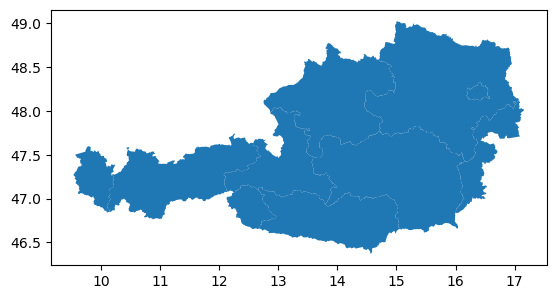

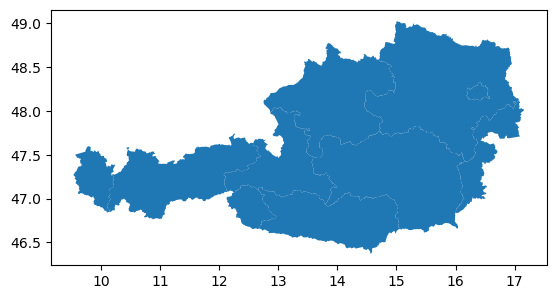

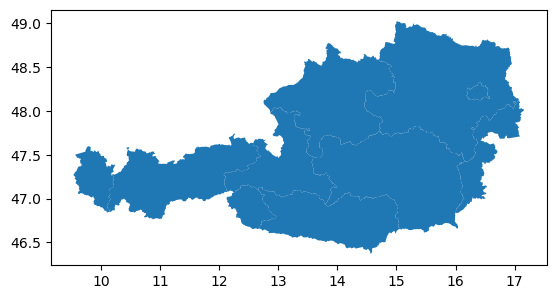

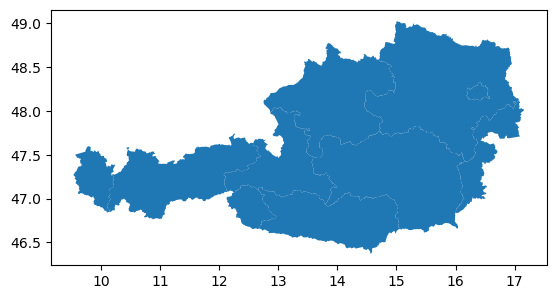

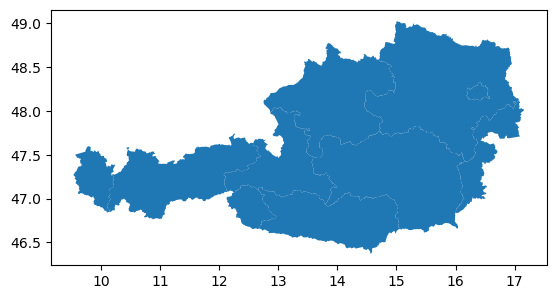

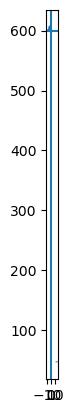

In [822]:
plt.plot(np.arange(-10, 0, .1), s)
plt.axhline(np.array(s)[np.array(s) == min(s)])
plt.axvline(np.arange(-10, 0, .1)[np.array(s) == min(s)])
plt.show()

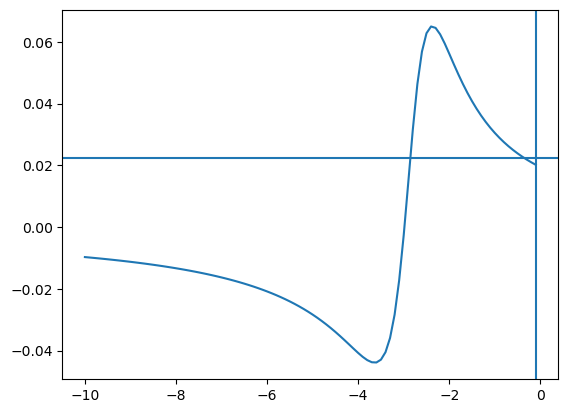

In [823]:
plt.plot(np.arange(-10, 0, .1), b)
plt.axhline(betas[-1][0])
plt.axvline(np.arange(-10, 0, .1)[np.array(s) == min(s)])
plt.show()

In [491]:
np.array(b)[np.array(s) == min(s)]

array([-0.00016196])

In [477]:
betas[-1][0]

-0.7499588112751029

In [478]:
np.arange(-10, 0, .1)[np.array(s) == min(s)]

array([-2.5])

In [573]:
np.exp(np.exp(-2.9))

1.0565651478929938

/Users/toshan/anaconda3/envs/lagwr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [658]:
import libpysal.weights as sw

In [677]:
W = sw.distance.DistanceBand()

/Users/toshan/anaconda3/envs/lagwr/lib/python3.7/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [724]:
W = sw.distance.DistanceBand.from_dataframe(austria_shp, threshold=99999, binary=False, silence_warnings=True)
W = W.full()[0]
mask = W!=0
Aij = (W * Dja[0:9])
Aij = Aij[mask].reshape((9,8))
Aij = np.tile(np.sum(Aij, axis=1), 9).reshape((9,9))
Aij = Aij[mask].reshape((-1,1))

/Users/toshan/anaconda3/envs/lagwr/lib/python3.7/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [713]:
np.log(Aij)

array([[ 7.79741574],
       [11.02187542],
       [10.78215358],
       [ 8.41752769],
       [ 8.92683707],
       [ 9.29601974],
       [11.44227795],
       [ 8.65414789],
       [ 8.02032277],
       [11.02187542],
       [10.78215358],
       [ 8.41752769],
       [ 8.92683707],
       [ 9.29601974],
       [11.44227795],
       [ 8.65414789],
       [ 8.02032277],
       [ 7.79741574],
       [10.78215358],
       [ 8.41752769],
       [ 8.92683707],
       [ 9.29601974],
       [11.44227795],
       [ 8.65414789],
       [ 8.02032277],
       [ 7.79741574],
       [11.02187542],
       [ 8.41752769],
       [ 8.92683707],
       [ 9.29601974],
       [11.44227795],
       [ 8.65414789],
       [ 8.02032277],
       [ 7.79741574],
       [11.02187542],
       [10.78215358],
       [ 8.92683707],
       [ 9.29601974],
       [11.44227795],
       [ 8.65414789],
       [ 8.02032277],
       [ 7.79741574],
       [11.02187542],
       [10.78215358],
       [ 8.41752769],
       [ 9

In [705]:
Aij.shape

(72, 1)